*Setting up the environment and loading the data.*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Set Up Environment / Select data

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette('colorblind')

# Load the dataset
# Note: Adjust the path to your dataset location
df = pd.read_csv('fraud.csv')



In [ ]:
# Initial examination of the data
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows of the dataset:")
df.head()

Dataset shape: (498121, 10)

First few rows of the dataset:


,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,4,467,88.48,4,8,4,0.014989,0.189465,0.571429,0
1,3,1004,58.99,7,6,1,0.026892,0.058755,0.259259,0
2,1,162,14.00,4,5,4,0.006173,0.086420,4.000000,0
3,5,532,84.79,9,3,4,0.026316,0.159380,0.642857,0
4,5,890,42.16,4,0,0,0.021348,0.047371,0.210526,0


# 2. Data Cleaning

### Missing values

In [ ]:
# Check for missing values
print("\nMissing Values:")
display(df.isnull().sum())



Missing Values:


,0
trustLevel,0
totalScanTimeInSeconds,0
grandTotal,0
lineItemVoids,0
scansWithoutRegistration,0
quantityModifications,0
scannedLineItemsPerSecond,0
valuePerSecond,0
lineItemVoidsPerPosition,0
fraud,0


## Handle duplicates

In [ ]:
# Handle duplicates
duplicates = df.duplicated().sum()
print(f'Number of duplicate rows: {duplicates}')
df = df.drop_duplicates()

Number of duplicate rows: 0


## Visualize outliers -> Necessary?

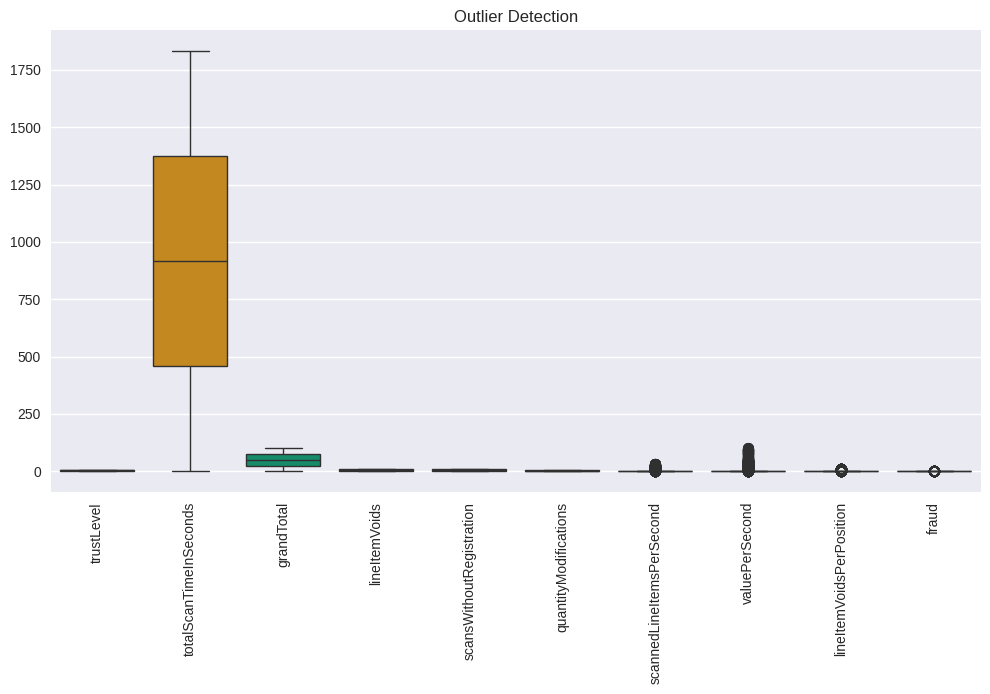

In [ ]:
# Visualizing outliers using boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df.select_dtypes(include=[np.number]))
plt.xticks(rotation=90)
plt.title("Outlier Detection")
plt.show()

# 3. Constructing Data

## Label Encoding
Based on the dataset preview, 'trustLevel' is categorical but numerical-looking.

Since it has a small number of unique values (likely ordinal in nature), we leave it as is.

The dataset does not contain text-based categorical features, so no need for label encoding.

## Create Derived Features

Scanefficiency -> Does this make sense?

In [ ]:
df["scanEfficiency"] = df["scannedLineItemsPerSecond"] * df["valuePerSecond"]

fraudactivityscore? -> Does this make sense?

In [ ]:
# - 'lineItemVoids' and 'scansWithoutRegistration' indicate potential fraud risk.
# - We create 'fraudActivityScore' as their product to highlight transactions with both issues.
df["fraudActivityScore"] = df["lineItemVoids"] * df["scansWithoutRegistration"]

## Binning

In [ ]:
# - 'grandTotal' is binned to categorize transaction amounts.
df["grandTotal_category"] = pd.cut(df["grandTotal"], bins=[0, 20, 100, np.inf], labels=["Low", "Medium", "High"])


In [ ]:
# - 'totalScanTimeInSeconds' is binned to classify checkout times.
df["scanTime_category"] = pd.cut(df["totalScanTimeInSeconds"], bins=[0, 300, 900, np.inf], labels=["Short", "Medium", "Long"])


## Normalize numerical features

**MinMax Scaled Dataset**

In [ ]:
df_minmax = df.copy()
numeric_cols = ["scannedLineItemsPerSecond", "valuePerSecond", "lineItemVoidsPerPosition"]
minmax_scaler = MinMaxScaler()
df_minmax[numeric_cols] = minmax_scaler.fit_transform(df_minmax[numeric_cols])

df_minmax.to_csv("dataset_minmax.csv", index=False)

**Standard Scaled Dataset**

In [ ]:
from sklearn.preprocessing import StandardScaler

df_std = df.copy()
std_scaler = StandardScaler()
df_std[numeric_cols] = std_scaler.fit_transform(df_std[numeric_cols])

df_std.to_csv("dataset_std.csv", index=False)

## Feature Reduction


Top feature correlations:
                     Feature1                   Feature2  Correlation  \
39  scannedLineItemsPerSecond             valuePerSecond     0.746334   
28              lineItemVoids   lineItemVoidsPerPosition     0.348968   
8                  trustLevel                      fraud    -0.299178   
13     totalScanTimeInSeconds  scannedLineItemsPerSecond    -0.169937   
14     totalScanTimeInSeconds             valuePerSecond    -0.168923   
16     totalScanTimeInSeconds                      fraud     0.101605   
44   lineItemVoidsPerPosition                      fraud    -0.081520   
34   scansWithoutRegistration                      fraud     0.080411   
21                 grandTotal             valuePerSecond     0.075609   
29              lineItemVoids                      fraud     0.069627   

    AbsCorrelation  
39        0.746334  
28        0.348968  
8         0.299178  
13        0.169937  
14        0.168923  
16        0.101605  
44        0.081520  
34

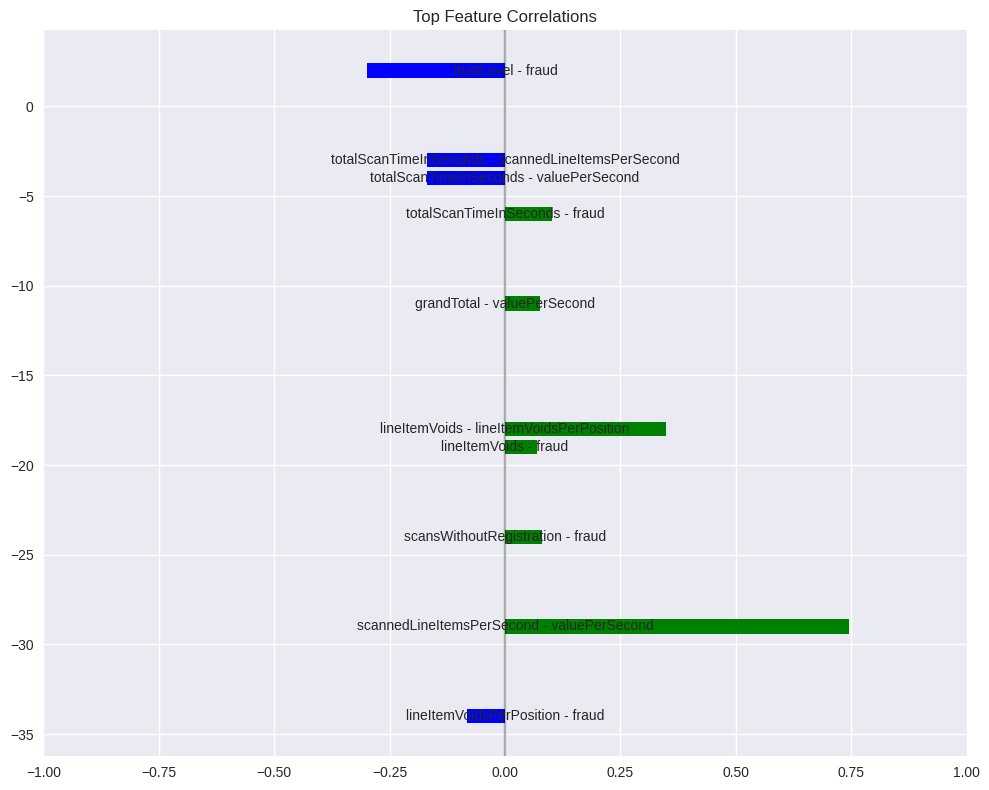

In [ ]:
corr_matrix = df.corr()

# Find the strongest correlations
# Creates a DataFrame of all pairwise correlations
corrs = []
for i, col1 in enumerate(corr_matrix.columns):
    for col2 in corr_matrix.columns[i+1:]:
        corrs.append({
            'Feature1': col1,
            'Feature2': col2,
            'Correlation': corr_matrix.loc[col1, col2]
        })

# Convert to DataFrame and sort by absolute correlation strength
corr_df = pd.DataFrame(corrs)
corr_df['AbsCorrelation'] = corr_df['Correlation'].abs()
corr_df = corr_df.sort_values('AbsCorrelation', ascending=False)

# Print top correlations
print("Top feature correlations:")
print(corr_df.head(10))

# Create a visualization similar to the Orange output
plt.figure(figsize=(10, 8))
for i, row in corr_df.head(10).iterrows():
    color = 'green' if row['Correlation'] > 0 else 'blue'
    plt.barh(10-i, row['Correlation'], color=color)
    plt.text(0, 10-i, f"{row['Feature1']} - {row['Feature2']}", ha='center', va='center')

plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.xlim(-1, 1)
plt.title('Top Feature Correlations')
plt.tight_layout()
plt.show()

Categorical columns: []
Numeric columns: ['trustLevel', 'totalScanTimeInSeconds', 'grandTotal', 'lineItemVoids', 'scansWithoutRegistration', 'quantityModifications', 'scannedLineItemsPerSecond', 'valuePerSecond', 'lineItemVoidsPerPosition', 'fraud']
Converted categorical columns to numeric

Top feature correlations:
                     Feature1                   Feature2  Correlation  \
39  scannedLineItemsPerSecond             valuePerSecond     0.746334   
28              lineItemVoids   lineItemVoidsPerPosition     0.348968   
8                  trustLevel                      fraud    -0.299178   
13     totalScanTimeInSeconds  scannedLineItemsPerSecond    -0.169937   
14     totalScanTimeInSeconds             valuePerSecond    -0.168923   
16     totalScanTimeInSeconds                      fraud     0.101605   
44   lineItemVoidsPerPosition                      fraud    -0.081520   
34   scansWithoutRegistration                      fraud     0.080411   
21                 grandT

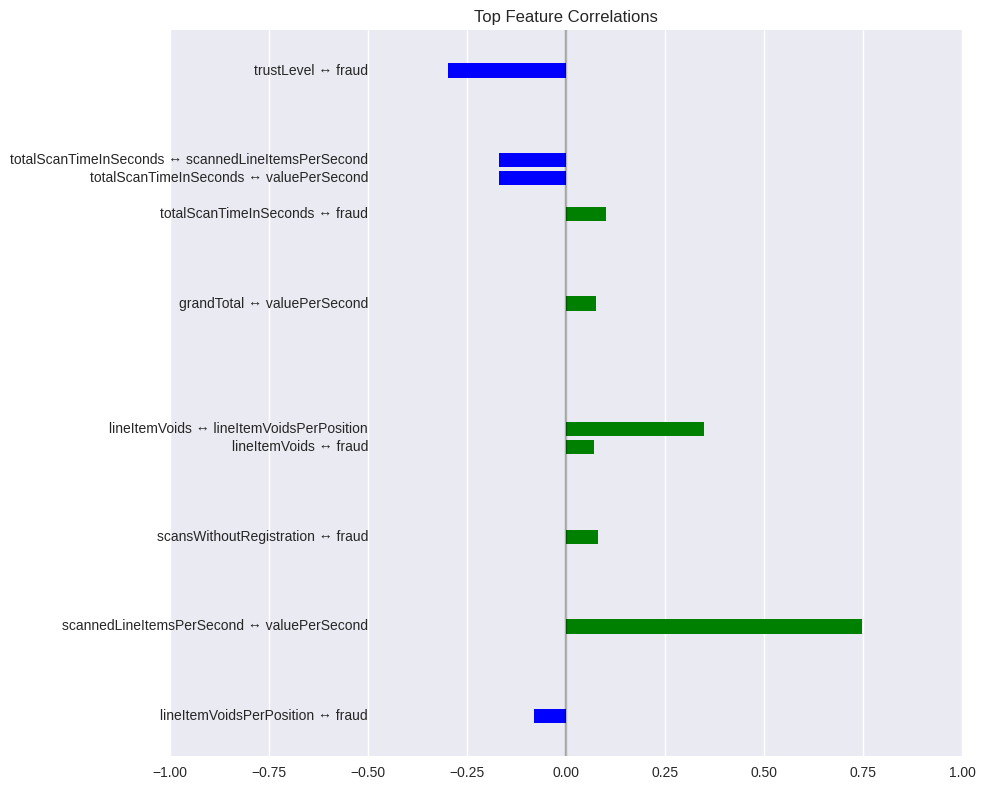


Correlations with fraud target:
fraud                        1.000000
totalScanTimeInSeconds       0.101605
scansWithoutRegistration     0.080411
lineItemVoids                0.069627
grandTotal                   0.007380
quantityModifications       -0.000437
scannedLineItemsPerSecond   -0.012009
valuePerSecond              -0.019326
lineItemVoidsPerPosition    -0.081520
trustLevel                  -0.299178
Name: fraud, dtype: float64


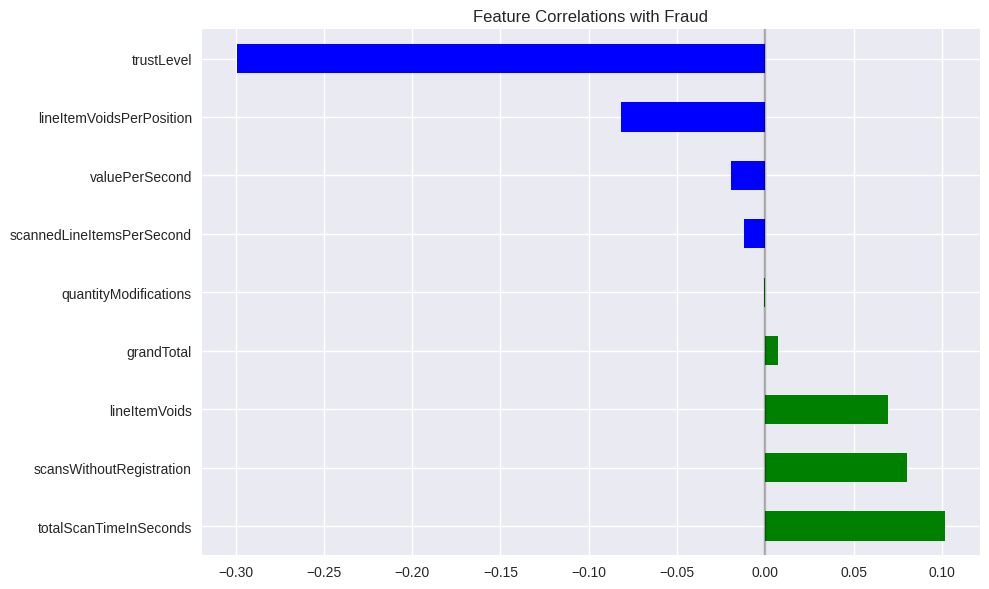

In [ ]:
# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

print(f"Categorical columns: {list(categorical_cols)}")
print(f"Numeric columns: {list(numeric_cols)}")

# Option 1: Convert categorical to numeric using label encoding
df_numeric = df.copy()
for col in categorical_cols:
    # Simple mapping for binary categories
    if df[col].nunique() == 2:
        # Get the two unique values
        unique_vals = df[col].unique()
        df_numeric[col] = df[col].map({unique_vals[0]: 0, unique_vals[1]: 1})
    else:
        # For columns with more categories, create a numeric encoding
        df_numeric[col] = pd.factorize(df[col])[0]

print("Converted categorical columns to numeric")

# Now calculate the correlation matrix
corr_matrix = df_numeric.corr()

# Find the strongest correlations
corrs = []
for i, col1 in enumerate(corr_matrix.columns):
    for col2 in corr_matrix.columns[i+1:]:
        corrs.append({
            'Feature1': col1,
            'Feature2': col2,
            'Correlation': corr_matrix.loc[col1, col2]
        })

# Convert to DataFrame and sort by absolute correlation strength
corr_df = pd.DataFrame(corrs)
corr_df['AbsCorrelation'] = corr_df['Correlation'].abs()
corr_df = corr_df.sort_values('AbsCorrelation', ascending=False)

# Print top correlations
print("\nTop feature correlations:")
print(corr_df.head(10))

# Create a visualization similar to the Orange output
plt.figure(figsize=(10, 8))
for i, row in corr_df.head(10).iterrows():
    color = 'green' if row['Correlation'] > 0 else 'blue'
    plt.barh(10-i, row['Correlation'], color=color)
    plt.text(-0.5, 10-i, f"{row['Feature1']} ↔ {row['Feature2']}", ha='right', va='center')

plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.xlim(-1, 1)
plt.yticks([])  # Hide y-axis ticks
plt.title('Top Feature Correlations')
plt.tight_layout()
plt.show()

# If 'fraud' is in the dataset, show correlations with fraud
if 'fraud' in df_numeric.columns:
    fraud_corr = corr_matrix['fraud'].sort_values(ascending=False)
    print("\nCorrelations with fraud target:")
    print(fraud_corr)

    # Visualize correlations with fraud
    plt.figure(figsize=(10, 6))
    colors = ['green' if x > 0 else 'blue' for x in fraud_corr]
    fraud_corr.drop('fraud').plot(kind='barh', color=colors)
    plt.title('Feature Correlations with Fraud')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.tight_layout()
    plt.show()

Dropping these columns for correlation analysis
Calculating correlation matrix...
Correlation matrix calculated successfully

Highly correlated feature pairs (|correlation| >= 0.7):
valuePerSecond - scanEfficiency: 0.7852
scannedLineItemsPerSecond - scanEfficiency: 0.7727
scannedLineItemsPerSecond - valuePerSecond: 0.7463

Feature correlations with fraud target:
fraud                        1.000000
trustLevel                   0.299178
totalScanTimeInSeconds       0.101605
fraudActivityScore           0.101112
lineItemVoidsPerPosition     0.081520
scansWithoutRegistration     0.080411
lineItemVoids                0.069627
valuePerSecond               0.019326
scannedLineItemsPerSecond    0.012009
grandTotal                   0.007380
scanEfficiency               0.005010
quantityModifications        0.000437
Name: fraud, dtype: float64
Keeping valuePerSecond (corr with fraud: 0.0193) and removing scanEfficiency (corr with fraud: 0.0050)
Keeping valuePerSecond (corr with fraud: 0.0193)

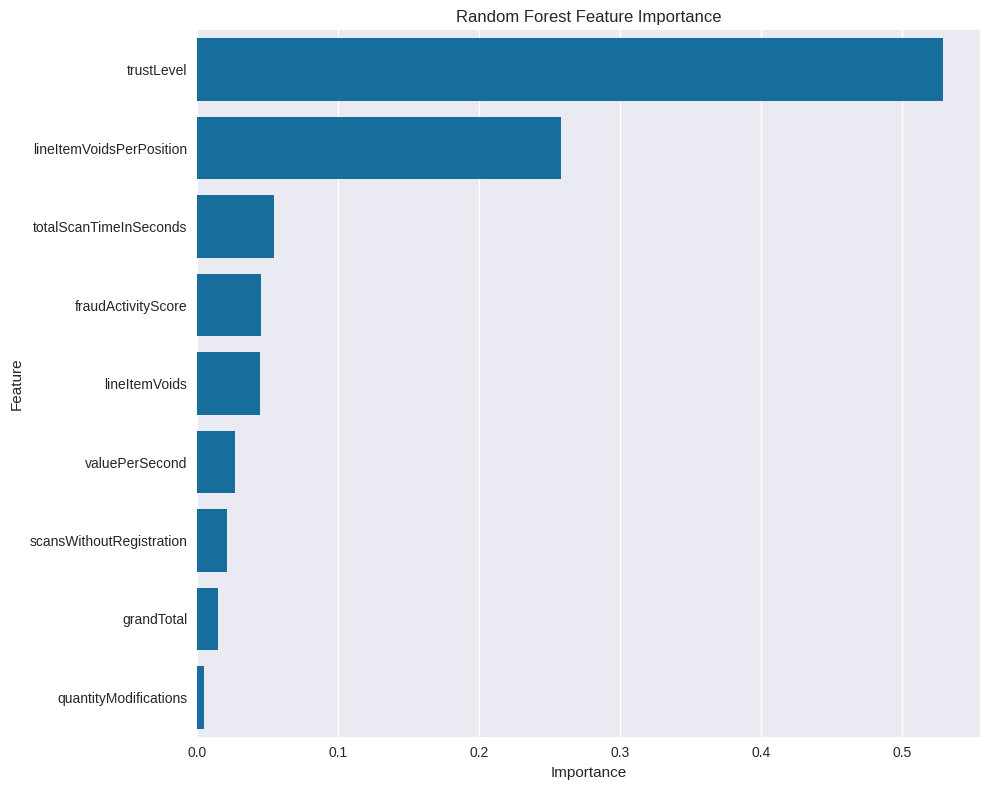


Top 10 most important features:
1. trustLevel (Importance: 0.5290)
2. lineItemVoidsPerPosition (Importance: 0.2582)
3. totalScanTimeInSeconds (Importance: 0.0545)
4. fraudActivityScore (Importance: 0.0455)
5. lineItemVoids (Importance: 0.0449)
6. valuePerSecond (Importance: 0.0267)
7. scansWithoutRegistration (Importance: 0.0213)
8. grandTotal (Importance: 0.0150)
9. quantityModifications (Importance: 0.0048)

Final recommended feature set:
- trustLevel (Importance: 0.5290, Correlation with fraud: 0.2992)
- lineItemVoidsPerPosition (Importance: 0.2582, Correlation with fraud: 0.0815)
- totalScanTimeInSeconds (Importance: 0.0545, Correlation with fraud: 0.1016)
- fraudActivityScore (Importance: 0.0455, Correlation with fraud: 0.1011)
- lineItemVoids (Importance: 0.0449, Correlation with fraud: 0.0696)
- valuePerSecond (Importance: 0.0267, Correlation with fraud: 0.0193)
- scansWithoutRegistration (Importance: 0.0213, Correlation with fraud: 0.0804)
- grandTotal (Importance: 0.0150, Cor

In [ ]:
# Identify categorical columns
object_columns = df.select_dtypes(include=['object']).columns
if len(object_columns) > 0:
    print(f"Categorical columns detected: {list(object_columns)}")

    # Print some sample values for debugging
    for col in object_columns:
        print(f"Column '{col}' unique values: {df[col].unique()[:5]}")

    # Convert categories to numeric
    for col in object_columns:
        df[col] = pd.Categorical(df[col]).codes

    print("Converted categorical columns to numeric codes")

# Check for any remaining non-numeric columns
non_numeric = df.select_dtypes(exclude=['number']).columns
if len(non_numeric) > 0:
    print(f"Warning: Non-numeric columns still present: {list(non_numeric)}")
    print("Dropping these columns for correlation analysis")
    df = df.select_dtypes(include=['number'])

# Step 1: Calculate correlation matrix
print("Calculating correlation matrix...")
corr_matrix = df.corr()
print("Correlation matrix calculated successfully")

# Find pairs of highly correlated features
threshold = 0.7  # Correlation threshold for considering features as highly correlated
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) >= threshold and corr_matrix.columns[i] != 'fraud' and corr_matrix.columns[j] != 'fraud':
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], abs(corr_matrix.iloc[i, j])))

# Sort by correlation strength
high_corr_pairs.sort(key=lambda x: x[2], reverse=True)

print("\nHighly correlated feature pairs (|correlation| >= 0.7):")
for col1, col2, corr in high_corr_pairs:
    print(f"{col1} - {col2}: {corr:.4f}")

# Calculate correlation with the target variable
if 'fraud' in corr_matrix.columns:
    fraud_corr = abs(corr_matrix['fraud']).sort_values(ascending=False)
    print("\nFeature correlations with fraud target:")
    print(fraud_corr)
else:
    print("\nWarning: 'fraud' column not found in correlation matrix")
    # If fraud is not in correlation matrix, use a dummy correlation
    fraud_corr = pd.Series(0, index=corr_matrix.columns)

# Function to decide which feature to keep from a correlated pair
def choose_feature_to_keep(col1, col2, fraud_corr):
    if fraud_corr.get(col1, 0) >= fraud_corr.get(col2, 0):
        return col1, col2  # Keep col1, remove col2
    else:
        return col2, col1  # Keep col2, remove col1

# Identify features to remove
features_to_remove = set()
for col1, col2, _ in high_corr_pairs:
    feature_to_keep, feature_to_remove = choose_feature_to_keep(col1, col2, fraud_corr)
    # Only add to removal list if it hasn't been marked for keeping in a previous pair
    if feature_to_remove not in features_to_remove:
        features_to_remove.add(feature_to_remove)
        print(f"Keeping {feature_to_keep} (corr with fraud: {fraud_corr.get(feature_to_keep, 0):.4f}) and removing {feature_to_remove} (corr with fraud: {fraud_corr.get(feature_to_remove, 0):.4f})")

# Remove highly correlated features
df_reduced = df.drop(columns=list(features_to_remove), errors='ignore')
print(f"\nReduced dataset shape after removing {len(features_to_remove)} highly correlated features: {df_reduced.shape}")
print(f"Removed features: {list(features_to_remove)}")

# Make sure fraud column exists for the next steps
if 'fraud' not in df_reduced.columns:
    print("Warning: 'fraud' column not found in dataset, can't proceed with feature ranking")
else:
    # Step 2: Feature ranking with Random Forest
    X = df_reduced.drop('fraud', axis=1)
    y = df_reduced['fraud']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Create and train Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    rf_model.fit(X_train, y_train)

    # Get feature importances
    feature_importances = rf_model.feature_importances_
    feature_names = X.columns

    # Create a DataFrame for easier visualization
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values('Importance', ascending=False)

    print("\nRandom Forest Feature Importance Ranking:")
    print(importance_df)

    # Plot feature importances
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Random Forest Feature Importance')
    plt.tight_layout()
    plt.show()

    # Select top N features based on importance
    N = 10  # Number of top features to keep
    top_features = importance_df.head(N)['Feature'].tolist()
    print(f"\nTop {N} most important features:")
    for i, feature in enumerate(top_features, 1):
        print(f"{i}. {feature} (Importance: {importance_df[importance_df['Feature'] == feature]['Importance'].values[0]:.4f})")

    # Final feature set recommendation
    print("\nFinal recommended feature set:")
    for feature in top_features:
        print(f"- {feature} (Importance: {importance_df[importance_df['Feature'] == feature]['Importance'].values[0]:.4f}, Correlation with fraud: {fraud_corr.get(feature, 0):.4f})")

## saved_constrcuted data

In [ ]:
# Save transformed dataset
df.to_csv("constructed_data.csv", index=False)

# 4. Integrate Data : N/A
We have only one data source

# 5. Format data

In [ ]:
categorical_cols = ["grandTotal_category", "scanTime_category"]
for col in categorical_cols:
    df[col] = df[col].astype("category")

Standardize remaining numerical features

In [ ]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# MODEL Random Forrest

In [ ]:
print("\n--- Model Training and Evaluation ---")

# Use the reduced dataset
X = df_reduced.drop('fraud', axis=1)
y = df_reduced['fraud']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]  # Probability of the positive class

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"ROC AUC: {auc:.4f}")

print("\nConfusion Matrix:")
print(conf_matrix)

# Calculate additional metrics
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)  # True Positive Rate / Recall
specificity = tn / (tn + fp)  # True Negative Rate
precision = tp / (tp + fp)
f1 = 2 * (precision * sensitivity) / (precision + sensitivity)

print(f"\nSensitivity (TPR): {sensitivity:.4f}")
print(f"Specificity (TNR): {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# You can also try with just the top N features
N = 6  # Using top 6 features as you suggested
top_features = importance_df.head(N)['Feature'].tolist()

print(f"\n--- Model with Top {N} Features Only ---")
X_top = df_reduced[top_features]
X_train_top, X_test_top, y_train, y_test = train_test_split(X_top, y, test_size=0.3, random_state=42, stratify=y)

rf_model_top = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model_top.fit(X_train_top, y_train)

y_pred_top = rf_model_top.predict(X_test_top)
y_prob_top = rf_model_top.predict_proba(X_test_top)[:, 1]

accuracy_top = accuracy_score(y_test, y_pred_top)
auc_top = roc_auc_score(y_test, y_prob_top)

print(f"\nAccuracy (top features): {accuracy_top:.4f}")
print(f"ROC AUC (top features): {auc_top:.4f}")
print("\nClassification Report (top features):")
print(classification_report(y_test, y_pred_top))


--- Model Training and Evaluation ---
Training set shape: (348684, 9)
Testing set shape: (149437, 9)

Accuracy: 0.9933
ROC AUC: 0.9981

Confusion Matrix:
[[142076    243]
 [   753   6365]]

Sensitivity (TPR): 0.8942
Specificity (TNR): 0.9983
Precision: 0.9632
F1 Score: 0.9274

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    142319
           1       0.96      0.89      0.93      7118

    accuracy                           0.99    149437
   macro avg       0.98      0.95      0.96    149437
weighted avg       0.99      0.99      0.99    149437


--- Model with Top 6 Features Only ---

Accuracy (top features): 0.9937
ROC AUC (top features): 0.9957

Classification Report (top features):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    142319
           1       0.96      0.91      0.93      7118

    accuracy                           0.99    149437
   macro a